# Chapter 5 - Optimal detection statistic

This notebook is based in part on https://github.com/losc-tutorial/Data_Guide, and introduces the match filter.


## Imports

We will need some standard imports for this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.signal import get_window

And we will need the GW-specific software `gwpy` and `pycbc`:

In [3]:
! pip install -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 14.4 MB/s eta 0:00:00


In [4]:
! pip install -q lalsuite pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 KB 4.4

In [5]:
from gwpy.timeseries import TimeSeries

## Get the data

In [6]:
time_center = 1126259462

In [7]:
# This might be the slowest cell execution, as it downloads the data. Run it only once !
strain_H1 = TimeSeries.fetch_open_data('H1', time_center - 512, time_center + 512)

## Fourier transforms

### Normalisations

We have seen so far three implementation of FFTs, all with different normalisations:
- numpy FFT, which implements the DFT without any normalisation
- gwpy FFT, which applies the 1/N normalisation, thereby providing the actual DFT values
- pycbc FFT, which applies a delta_t normalisation, thereby being our standard Fourier Transform (equations 0.1 of the textbook) in the continuous limit

In [8]:
# Setting up a test Time Series:
timeseries = TimeSeries([1.0, 0.0, -1.0, 0.0], sample_rate=.1)

In [9]:
# Numpy FFT:
np.fft.rfft(timeseries)

<TimeSeries([0.+0.j, 2.+0.j, 0.+0.j]
            unit=Unit(dimensionless),
            t0=<Quantity 0. s>,
            dt=<Quantity 10. s>,
            name=None,
            channel=None)>

In [10]:
# GWpy FFT:
timeseries.fft()

<FrequencySeries([0.+0.j, 1.+0.j, 0.+0.j]
                 unit=Unit(dimensionless),
                 f0=<Quantity 0. Hz>,
                 df=<Quantity 0.025 Hz>,
                 epoch=<Time object: scale='utc' format='gps' value=0.0>,
                 name=None,
                 channel=None)>

In [11]:
# pyCBC FFT:
ts_pycbc=timeseries.to_pycbc()
print(ts_pycbc.to_frequencyseries())

[ 0.+0.j 20.+0.j  0.+0.j]


All have their advantages: `numpy`'s convention is simplest, and lets the user use that FFT with the normalisation they wish (remember, the FFT can be used for many computations, e.g. correlations). `GWpy`'s is the standard DFT, and does not change value for longer time series, representing instead the underlying frequency features independently of the lenght of time they are recorded. It is in general the best one for engineering applications, such as detector commissioning or characterisation. `pyCBC`'s is the one that relates most straightforwardly to the standard continuous Fourier transform, and is in general the better one for signal analysis and computing overlaps, matches and SNR.

All those conventions are self-consistent, and it is always possible to go from one to the other. It's important to keep track, and it can be useful to choose the convention where the calculations one wants to do are simplest:

In [12]:
# Numpy FFT:
np.fft.rfft(timeseries)*timeseries.dt.value

<TimeSeries([ 0.+0.j, 20.+0.j,  0.+0.j]
            unit=Unit(dimensionless),
            t0=<Quantity 0. s>,
            dt=<Quantity 10. s>,
            name=None,
            channel=None)>

In [13]:
# GWpy FFT:
timeseries.fft()*timeseries.duration.value/2

<FrequencySeries([ 0.+0.j, 20.+0.j,  0.+0.j]
                 unit=Unit(dimensionless),
                 f0=<Quantity 0. Hz>,
                 df=<Quantity 0.025 Hz>,
                 epoch=<Time object: scale='utc' format='gps' value=0.0>,
                 name=None,
                 channel=None)>

### Windows

Remember how we need to window the data to take FFTs without artifact? As we are reducing the data by some amount with the window, in practice we need to correct by a scaling factor of the window's mean:

In [14]:
window=get_window(('tukey',1./4.),strain_H1.size)
scaling_factor=np.abs(window).mean()

strain_H1_fft=(strain_H1*window).fft()/scaling_factor
strain_H1_afft=strain_H1.average_fft(window=('tukey',1./4.)) # built-in function which already includes the normalisation

<Figure size 576x576 with 0 Axes>

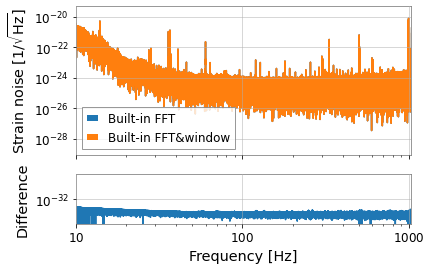

In [15]:
plt.figure(figsize=(8, 8))

f, (a0, a1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

a0.loglog(strain_H1_fft.frequencies,np.abs(strain_H1_fft),label='Built-in FFT')
a0.loglog(strain_H1_afft.frequencies,np.abs(strain_H1_afft),label='Built-in FFT&window')
a0.set_ylabel('Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
a0.legend(loc='lower left')

a1.loglog(strain_H1_fft.frequencies,np.abs(strain_H1_fft-strain_H1_afft))
a1.set_ylabel('Difference')

a1.set_xlabel('Frequency [Hz]')
a1.set_xlim(10,1024);


We can now simply use the `average_fft()` method which includes the window scaling factor.

## Calculate the noise power spectral density (PSD)

You have seen how to compute the amplitude spectrum manually last week. To get the Power Spectrum Density (PSD), from its definition (e.g. equation 7.6 in the textbook), we need a factor of $\frac{2}{T}$:



In [16]:
normalised_fft=strain_H1.average_fft(window=('tukey',1./4.))*(strain_H1.duration.value/2)

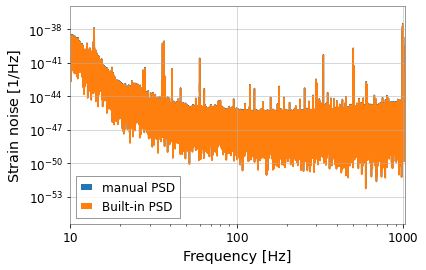

In [17]:
plt.loglog((2/strain_H1.duration.value)*np.abs(normalised_fft)**2,label='manual PSD')
plt.loglog(strain_H1.psd(window=('tukey',1./4.)),label='Built-in PSD')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.xlim(10,1024)
plt.legend();

Instead of keeping track of all the factors manually each time, we should write a function we can call. Or, better yet, use the ones already implemented _now that we know what they do_. Here we will use the `TimeSeries`'s `.psd()` method directly. Do look at the help message with

```python
help(strain_H1.psd)
```

And make note of any argument that might not be clear to discuss in class.

To redude the variance in the PSD, we can average over several PSDs:

In [18]:
Pxx_H1=strain_H1.psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

# A shorter section of the data, of the same lenght of the individual elements we are averaging over above:
strain_H1_4s=strain_H1.crop(time_center - 2,time_center + 2)

tukey_Pxx_H1=strain_H1_4s.psd(fftlength=4.,window=('tukey',1./4.))
nowin_Pxx_H1=strain_H1_4s.psd(fftlength=4.,window='boxcar')

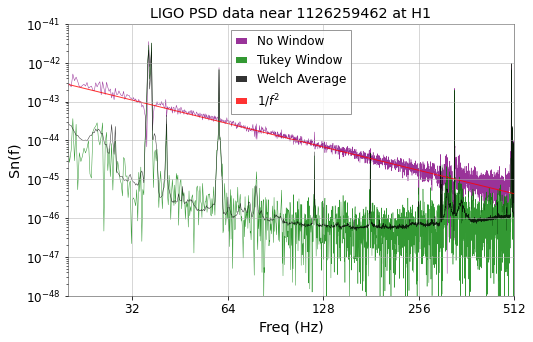

In [19]:
plt.figure(figsize=(8, 5))
# scale x and y axes
plt.xscale('log', base=2)
plt.yscale('log', base=10)

# plot nowindow, tukey, welch together 
plt.plot(nowin_Pxx_H1.frequencies, nowin_Pxx_H1,'purple',label= 'No Window',
         alpha=.8, linewidth=.5)
plt.plot(tukey_Pxx_H1.frequencies, tukey_Pxx_H1 ,'green',label='Tukey Window',
         alpha=.8, linewidth=.5)
plt.plot(Pxx_H1.frequencies, Pxx_H1,'black',label='Welch Average', alpha=.8,
         linewidth=.5)

# plot 1/f^2
# give it the right starting scale to fit with the rest of the plots
# don't include zero frequency
scale=nowin_Pxx_H1.value_at(32)*(32**2)
plt.plot(nowin_Pxx_H1.frequencies[1:], scale/nowin_Pxx_H1.frequencies[1:]**2,'red',
         label= r'$1 / f^2$', alpha=.8, linewidth=1)


plt.axis([20, 512, 1e-48, 1e-41])
plt.ylabel('Sn(f)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('LIGO PSD data near ' + str(time_center) + ' at H1')
plt.show()


# **Question**
- Try to reproduce the [Welch Average](https://en.wikipedia.org/wiki/Welch%27s_method) PSD manually, by computing PSDs in chunks of time of 4 seconds long, overlapping by 2 seconds (e.g., every point in the time series gets included in the calculation of 2 PSDs), and take the average.

Note that inadequate windowing of these strongly colored data produces a psd that 
is entirely dominated by "spectral leakage",
https://en.wikipedia.org/wiki/Spectral_leakage,
and inadequate averaging leads to noise fluctuations that contaminate the estimated PSD.


## Plot strain data that has been windowed, bandpassed, and whitened

In the chapter 4 notebook you applied _filters_ to the data: transforming a time series in the frequency domain, multiplying the frequency series by a function to remove or downweigh some frequency, and converting the result back into the time domain.

We can use the amplitude spectral density for this operation, i.e. whitening the data:

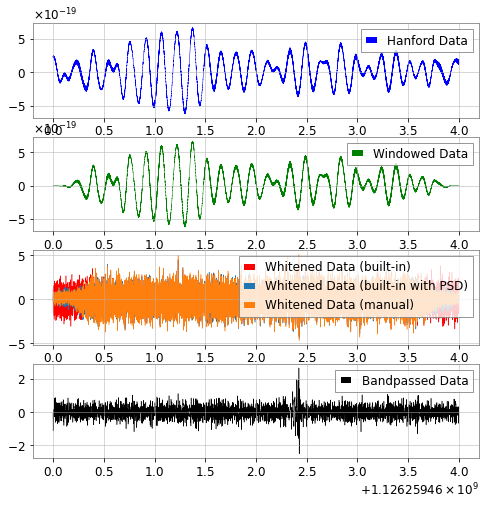

In [20]:
# plot original strain data
plt.figure(figsize=(8, 8))
plt.subplot(4, 1, 1)

plt.plot(strain_H1_4s.times, strain_H1_4s, 'blue', 
         label='Hanford Data', linewidth=.5)
plt.legend()

# plot windowed data
plt.subplot(4, 1, 2)
strain_H1_4s_win=strain_H1_4s*get_window(('tukey',1./4.),strain_H1_4s.size)
plt.plot(strain_H1_4s_win.times, strain_H1_4s_win, 'green', 
         label='Windowed Data', linewidth=.5)
plt.legend()

# plot whitened data
plt.subplot(4, 1, 3)

# For demonstration purposes, we are computing the whitened data in 3 ways.
# First, using the built-in "whiten" function, using it to compute the PSD on
# the whole data (identically to the calculations in the previous section)
# and only keeping the 4 seconds of interest.
strain_H1_white = strain_H1.whiten(fftlength=4,overlap=2,window=('tukey',1./4.))
strain_white=strain_H1_white.crop(time_center - 2,time_center + 2)

# We can also use the "whiten" function directly on the 4-second long data segment,
# however, as it does not have enough data for an accurate PSD estimation with averages,
# we pass directly the value of the ASD.
strain_white_v2 = strain_H1_4s_win.whiten(asd=np.sqrt(Pxx_H1),window=('tukey',1./4.))

# Finally, we can also do it all manually, dividing by the ASD=PSD**0.5, and taking care
# of the normalisation.
strain_white_v3 =(strain_H1_4s.average_fft(window=('tukey',1./4.))/(Pxx_H1**(1/2))).ifft()*(1./np.sqrt(1./(strain_H1_4s.dt*2)))

plt.plot(strain_white.times, strain_white, 'red', 
         label='Whitened Data (built-in)', linewidth=.5)
plt.plot(strain_white_v2.times, strain_white_v2, 
         label='Whitened Data (built-in with PSD)', linewidth=.5)
plt.plot(strain_white_v3.times, strain_white_v3, 
         label='Whitened Data (manual)', linewidth=.5)
plt.legend()

# plot bandpassed data
plt.subplot(4, 1, 4)
strain_bp = strain_white.bandpass(35.,350.)
plt.plot(strain_bp.times, strain_bp, 'black', 
         label='Bandpassed Data', linewidth=.5)

plt.legend()
#plt.yticks([-6, -3, 0, 3, 6, 9])
#plt.tight_layout()
#plt.xlim([-2, 2])
#plt.ylim([-8, 8])
plt.show()


## Fourier phases

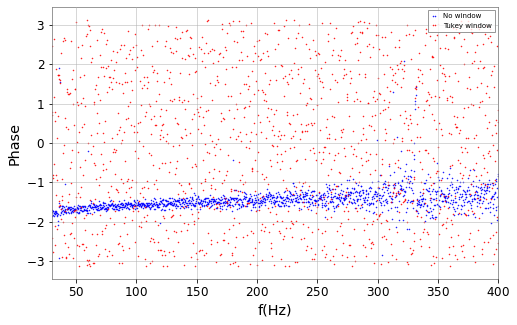

In [21]:
# Plots Fourier phases of strain data both with and without a spectral window
plt.figure(figsize=(8, 5))

strain_H1_fft = strain_H1_4s.average_fft()
strain_H1_fft_win = strain_H1_4s.average_fft(window=('tukey',1./4.))

plt.plot(strain_H1_fft.frequencies, np.angle(strain_H1_fft), '.', label='No window', color='blue', markersize=1)
plt.plot(strain_H1_fft_win.frequencies, np.angle(strain_H1_fft_win), '.', label='Tukey window', color='red', markersize=1)

plt.xlim([30, 400])
plt.xlabel('f(Hz)')
plt.ylabel('Phase')
plt.legend(loc='upper right', fontsize=7)

Note that the fourier phases for properly windowed data (random noise) are random between [0, 2*pi];
by contrast, un-windowed data produce strongly correlated fourier phases that are artifacts of the abrupt beginning and end of the data stretch.

## Generate, taper, and zero-pad the waveform template

In [22]:
# Importing the waveform generators
from pycbc.waveform import get_td_waveform

We will generate a gravitational waveform below, taking values from [this paper](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.116.241102). However, do note the following caveats that apply, and which we will cover later in class:
* we are ignoring correlations between parameters.
* we are ignoring network effects, and only use the "plus" polarisation of the signal
* we are taking mean 1D-posterior density values, ignoring prior and density effects

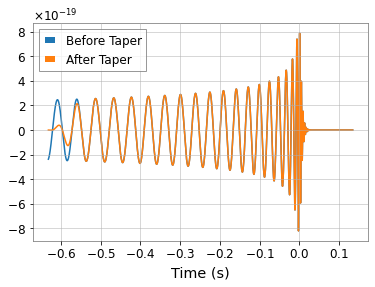

In [23]:
m1 = 38.9 # Solar masses
m2 = 31.6 # Solar masses

h_plus, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H1.dt.value,
                     f_lower=20)

plt.plot(h_plus.sample_times, h_plus,label='Before Taper')
plt.plot(h_plus.sample_times, h_plus*get_window(('tukey',1/4),h_plus.shape[0]),label='After Taper')
plt.xlabel('Time (s)')
plt.legend()

The effect of the tapering Tukey window is visible at the beginning of the template.  Tapering forces the template to have zero values at the ends, in order to avoid artefacts due to discontinuities when taking an FFT.

# Chapter 6 - Matched filter

## Calculate the matched filter result for GW150914

Note, the results of matched filtering are sensitive to small changes in PSD estimation, and so running similar codes may not give identical results. The calculated SNR is particularly sensitive, and differences of a few percent between different implementations are typically expected.

In [24]:
strain_H1_white = strain_H1.whiten(fftlength=4,overlap=2,window=('tukey',1./4.))
# Getting a more manageable 32 seconds of data:
strain_white=strain_H1_white.crop(time_center - 16,time_center + 16)

In [25]:
# Badpassing the whitened strain with specific values are defined in the detection paper
strain_bp=strain_white.bandpass(35.,350.)

Text(0.5, 0, 'time [s]')

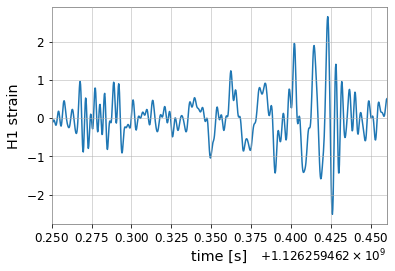

In [26]:
plt.plot(strain_bp)
plt.xlim(time_center+0.25,time_center+0.46)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')

As we have see in previous notebooks, this is were the signal is. Now we will set-up the template to match-filter the data:

In [27]:
# Making it 32 seconds:
h_plus.prepend_zeros(np.ceil((16+h_plus.start_time)/h_plus.delta_t))
h_plus.append_zeros(np.floor((16-h_plus.end_time)/h_plus.delta_t))

template=TimeSeries.from_pycbc(h_plus)
template.duration

<Quantity 32. s>

In [28]:
# Same with the data:
strain_H1_32=strain_H1.crop(time_center - 16,time_center + 16)

In [29]:
# FFT of the data, with the appropriate normalisation
data_f=strain_H1_32.average_fft(window=('tukey',1./4.))*(strain_H1_32.duration/2)

In [30]:
# FFT of the template, with the appropriate normalisation
template_f=template.average_fft(window=('tukey',1./4.))*(template.duration/2)

In [31]:
# We will need the PSD with the same frequency spacing as the data and template,
# so we interpolate it to match:
Pxx_H1_32=Pxx_H1.interpolate(data_f.df.value)

In [32]:
# With the right normalisation, this is equation 7.58 of the textbook:
optimal=data_f*template_f.conjugate()/Pxx_H1_32
opt_time=2*optimal.ifft()*(optimal.df*2)

In [33]:
# This is equation 7.49 of the textbook: the overlap of the template with itself
sigmasq = 4 * np.real((template_f * template_f.conjugate() / Pxx_H1_32).sum() * template_f.df)
sigma = np.sqrt(np.abs(sigmasq))

# And now we have the SNR time series:
SNR_complex = opt_time/sigma

In [34]:
# We can recenter thing with the location of peak in the template:
peaksample = template.argmax()  
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

In [35]:
SNRmax=SNR.max().value
time_max=SNR.times[SNR.argmax()]
print('Maximum SNR of {} at {}.'.format(SNRmax,time_max))

Maximum SNR of 21.414764299371672 at 1126259462.4260254 1 / Hz.


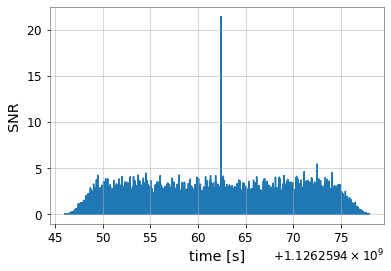

In [36]:
plt.plot(SNR.times,SNR)
plt.xlabel('time [s]')
plt.ylabel('SNR');

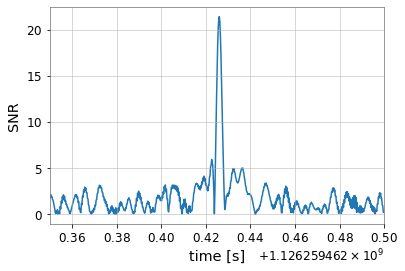

In [37]:
plt.plot(SNR.times,SNR)
plt.xlim(time_center+0.35,time_center+0.5)
plt.xlabel('time [s]')
plt.ylabel('SNR');

# **Questions**

- Compare to how much better this is than the correlation in chapter3
- why is it not exactly at `time_center` ?
- do this for `L1` !

We can find the amplitude and phase that maximise the likelihood to plot the template:

In [38]:
# This is equation 7.47 of the textbook
a_max=SNRmax/sigma

In [39]:
# Getting the optimal phase from the complex SNR:
phase = -np.angle(SNR_complex[SNR.argmax()])

In [40]:
# adjust the amplitude, phase and time of the template:
template_transformed=(template.fft()*np.exp(- 1.j * phase.value)).ifft()*a_max
template_transformed.x0=template.x0+time_max

In [41]:
# whitening and bandpassing the template in the same way we did the data for comparison:
template_whitened_bandpassed=template_transformed.whiten(asd=np.sqrt(Pxx_H1),window=('tukey',1./4.)).bandpass(35.,350.)

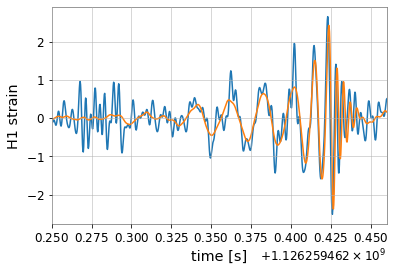

In [42]:
plt.plot(strain_bp)
plt.plot(template_whitened_bandpassed)
plt.xlim(time_center+0.25,time_center+0.46)
plt.ylabel('H1 strain')
plt.xlabel('time [s]');

## Calculating the background and significance

This is an illustrative example of significance measurement, using p-values. In practice we can use multiple detectors to get much better statistics. 

We calculate the peak in the SNR for a given window around the observed SNR peak, this is our "on-source" value. To determine the significance of the on-source we will compare how likely it is for a peak as large or larger to appear in the background. Our background will be empirically measured by taking portions of the SNR time series from the "off-source" i.e. times that do not overlap the on-source. An important criteria to avoid a biased significance estimate is that the background and experiment be performed in the same manner.

In [43]:
# convert the times to indices along with how large the region is in number of samples:
window_size = int((1) / SNR.dt.value)
sidx = int((float(-0.25+time_center-SNR.x0.value)) / SNR.dt.value)
eidx = sidx + window_size

For this illustrative example, our choice of window is arbitrary, and we check that the "on-source" does contain the peak SNR:

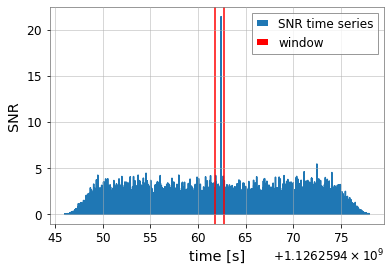

In [44]:
plt.plot(SNR,label='SNR time series')
plt.axvline(SNR.times[sidx].value,c='r',label='window')
plt.axvline(SNR.times[eidx].value,c='r')
plt.xlabel('time [s]')
plt.ylabel('SNR')
plt.legend();

In [45]:
# Calculate the "on-source" peak SNR statistic value.
onsource = SNR[sidx:eidx].max()

In [46]:
# Now that we've calculated the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks = []
i = 0
while i + window_size < len(SNR):
    p = SNR[i:i+window_size].max()
    peaks.append(p)
    i += window_size
    
    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2
    
peaks = np.array([p.value for p in peaks])

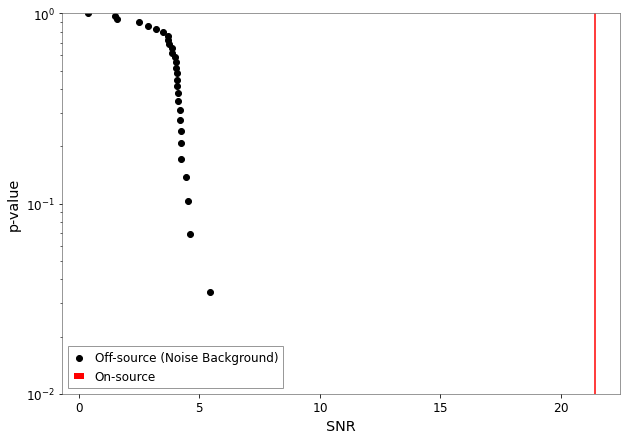

The p-value associated with the GW150914 peak is 0.0


In [47]:
# The p-value is just the number of samples observed in the background with a 
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = np.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource.value).sum() / float(len(peaks))

plt.figure(figsize=[10, 7])
plt.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

plt.axvline(onsource.value, label='On-source', color='red')
plt.axhline(pvalue, color='red')

plt.legend()
plt.yscale('log')
plt.grid()
plt.ylim(1e-2, 1e0)
plt.ylabel('p-value')
plt.xlabel('SNR')

plt.show()

print("The p-value associated with the GW150914 peak is {}".format(pvalue))

# **Questions**

- Why is the p-value associated with the peak zero? What does that mean?
- How can we use multiple detector's data to improve our significance measurement?